<a href="https://colab.research.google.com/github/Hend-Khaled-Aly/ITI_NLP/blob/main/RNN_larger_batch_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
from sklearn.metrics import accuracy_score
import time

<ipython-input-2-83d27269306b>:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
x = torch.tensor([4,5])
y = torch.tensor([1,9])
torch.cat((x,y))
z = torch.sigmoid(x)
g = torch.dot(x,y)
g

tensor(49)

In [4]:
D = 28*28
n = 256
C = 1
classes = 10

In [5]:
model_regular = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, n),
    nn.Tanh(),
    nn.Linear(n, n),
    nn.Tanh(),
    nn.Linear(n, n),
    nn.Tanh(),
    nn.Linear(n, classes),
)

In [6]:
h_2 = nn.Linear(n, n)

In [7]:
model_shared = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, n),
    nn.Tanh(), h_2,
    nn.Tanh(), h_2,
    nn.Tanh(),
    nn.Linear(n, classes),
)

**Building RNN Network**

In [19]:
import requests, zipfile, io
import unicodedata
import string
from torch.nn.utils.rnn import pad_sequence

In [12]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [13]:
namge_language_data = {}

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i


In [14]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [15]:
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [unicodeToAscii(line).lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names)) #Print out the name of each language too.


Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [16]:
namge_language_data.keys()

dict_keys(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'])

In [17]:
print("First 10 Arabic names in the dataset:")
for i, name in enumerate(namge_language_data["Arabic"][:10], 1):
    print(f"{i}. {name}")

First 10 Arabic names in the dataset:
1. khoury
2. nahas
3. daher
4. gerges
5. nazari
6. maalouf
7. gerges
8. naifeh
9. guirguis
10. baba


In [18]:
class LanguageNameDataset(Dataset):

    def __init__(self, lang_name_dict, vocabulary):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):

        T = len(input_string)
        name_vec = torch.zeros((T), dtype=torch.long)

        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]

        return name_vec

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        label_vec = torch.tensor([label], dtype=torch.long)

        return self.string2InputVec(name), label


In [20]:
def collate_fn(batch):
    names, labels = zip(*batch)
    padded_names = pad_sequence(names, batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.long)

    return padded_names, labels


In [21]:
dataset = LanguageNameDataset(namge_language_data, alphabet)
train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset)-300, 300))
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [22]:
with torch.no_grad():
    input_sequence = torch.tensor([0, 1, 1, 0, 2], dtype=torch.long)
    embd = nn.Embedding(3, 2)
    x_seq = embd(input_sequence)
    print(input_sequence.shape, x_seq.shape)
    print(x_seq)

torch.Size([5]) torch.Size([5, 2])
tensor([[ 0.5115, -0.8885],
        [ 1.4452, -0.1499],
        [ 1.4452, -0.1499],
        [ 0.5115, -0.8885],
        [ 0.1078, -2.8480]])


In [23]:
class LastTimeStep(nn.Module):

    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1

    def forward(self, input):
        rnn_output = input[0]
        last_step = input[1]
        if(type(last_step) == tuple):
            last_step = last_step[0]
        batch_size = last_step.shape[1]
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        last_step = last_step[self.rnn_layers-1]
        last_step = last_step.permute(1, 0, 2)
        return last_step.reshape(batch_size, -1)



In [24]:
D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
  nn.Embedding(vocab_size, D),
  nn.RNN(D, hidden_nodes, batch_first=True),
  LastTimeStep(),
  nn.Linear(hidden_nodes, classes),
)


In [25]:
def moveTo(obj, device):

    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj

In [26]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):

    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs)
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    end = time.time()

    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)

    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start

In [27]:
def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001):

    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )

    total_train_time = 0
    results = {}
    for item in to_track:
        results[item] = []

    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [29]:
loss_func = nn.CrossEntropyLoss()
batch_one_train = train_simple_network(first_rnn,
                                    loss_func,
                                    train_loader,
                                    test_loader=test_loader,
                                    score_funcs={'Accuracy': accuracy_score},
                                    device='cpu', epochs=70)


Epoch:   0%|          | 0/70 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

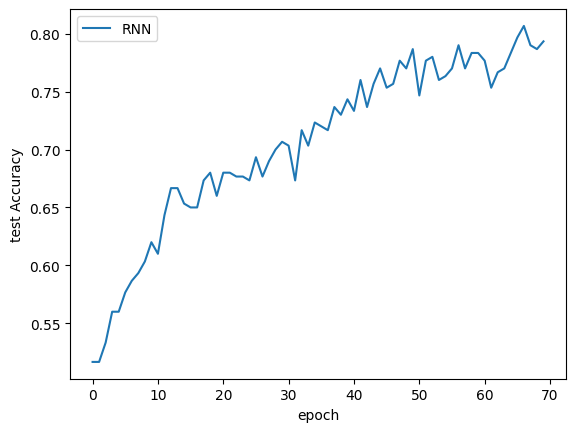

In [30]:
sns.lineplot(x='epoch', y='test Accuracy', data=batch_one_train, label='RNN')

In [31]:
pred_rnn = first_rnn.to("cpu").eval()
with torch.inference_mode():
    preds = F.softmax(pred_rnn(dataset.string2InputVec("frank").reshape(1,-1)), dim=-1)
    for class_id in range(len(dataset.label_names)):
        print(dataset.label_names[class_id], ":", preds[0,class_id].item()*100 , "%")

Arabic : 0.21548632066696882 %
Chinese : 0.21305668633431196 %
Czech : 1.9783403724431992 %
Dutch : 16.187983751296997 %
English : 14.879493415355682 %
French : 3.9883796125650406 %
German : 29.611435532569885 %
Greek : 0.32436030451208353 %
Irish : 10.044115036725998 %
Italian : 0.6351882126182318 %
Japanese : 0.06175665184855461 %
Korean : 0.45263622887432575 %
Polish : 0.9972437284886837 %
Portuguese : 0.6923263892531395 %
Russian : 14.494286477565765 %
Scottish : 3.904235363006592 %
Spanish : 0.7123803254216909 %
Vietnamese : 0.6072896998375654 %
